In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                                      | 0/50000 [00:00<?, ?it/s]

  9%|██████████▍                                                                                                             | 4356/50000 [00:00<00:01, 43553.60it/s]

 17%|████████████████████▉                                                                                                   | 8748/50000 [00:00<00:00, 43763.43it/s]

 26%|███████████████████████████████▏                                                                                       | 13125/50000 [00:00<00:00, 43636.58it/s]

 35%|█████████████████████████████████████████▊                                                                             | 17585/50000 [00:00<00:00, 44015.78it/s]

 44%|████████████████████████████████████████████████████▎                                                                  | 22001/50000 [00:00<00:00, 44066.64it/s]

 53%|██████████████████████████████████████████████████████████████▊                                                        | 26408/50000 [00:00<00:00, 44023.30it/s]

 62%|█████████████████████████████████████████████████████████████████████████▍                                             | 30862/50000 [00:00<00:00, 44191.55it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████                                   | 35310/50000 [00:00<00:00, 44282.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                        | 39746/50000 [00:00<00:00, 44306.38it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 44211/50000 [00:01<00:00, 44410.34it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48653/50000 [00:01<00:00, 44335.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 44157.43it/s]

Files already downloaded and verified


  0%|                                                                                                                                      | 0/10000 [00:00<?, ?it/s]

 43%|███████████████████████████████████████████████████▎                                                                    | 4281/10000 [00:00<00:00, 42799.43it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8561/10000 [00:00<00:00, 42388.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 42667.66it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 za51lfb3


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                        | 0/157 [00:00<?, ?it/s]

  1%|▊                                                                                                                               | 1/157 [00:00<01:43,  1.51it/s]

  1%|█▋                                                                                                                              | 2/157 [00:00<00:53,  2.88it/s]

  2%|██▍                                                                                                                             | 3/157 [00:00<00:37,  4.07it/s]

  3%|███▎                                                                                                                            | 4/157 [00:01<00:30,  5.03it/s]

  3%|████                                                                                                                            | 5/157 [00:01<00:26,  5.78it/s]

  4%|████▉                                                                                                                           | 6/157 [00:01<00:23,  6.36it/s]

  4%|█████▋                                                                                                                          | 7/157 [00:01<00:22,  6.78it/s]

  5%|██████▌                                                                                                                         | 8/157 [00:01<00:21,  7.09it/s]

  6%|███████▎                                                                                                                        | 9/157 [00:01<00:20,  7.32it/s]

  6%|████████                                                                                                                       | 10/157 [00:01<00:19,  7.49it/s]

  7%|████████▉                                                                                                                      | 11/157 [00:01<00:19,  7.60it/s]

  8%|█████████▋                                                                                                                     | 12/157 [00:02<00:18,  7.68it/s]

  8%|██████████▌                                                                                                                    | 13/157 [00:02<00:18,  7.74it/s]

  9%|███████████▎                                                                                                                   | 14/157 [00:02<00:18,  7.78it/s]

 10%|████████████▏                                                                                                                  | 15/157 [00:02<00:18,  7.81it/s]

 10%|████████████▉                                                                                                                  | 16/157 [00:02<00:18,  7.83it/s]

 11%|█████████████▊                                                                                                                 | 17/157 [00:02<00:17,  7.84it/s]

 11%|██████████████▌                                                                                                                | 18/157 [00:02<00:17,  7.85it/s]

 12%|███████████████▎                                                                                                               | 19/157 [00:02<00:17,  7.86it/s]

 13%|████████████████▏                                                                                                              | 20/157 [00:03<00:17,  7.84it/s]

 13%|████████████████▉                                                                                                              | 21/157 [00:03<00:17,  7.85it/s]

 14%|█████████████████▊                                                                                                             | 22/157 [00:03<00:17,  7.85it/s]

 15%|██████████████████▌                                                                                                            | 23/157 [00:03<00:17,  7.86it/s]

 15%|███████████████████▍                                                                                                           | 24/157 [00:03<00:16,  7.86it/s]

 16%|████████████████████▏                                                                                                          | 25/157 [00:03<00:16,  7.86it/s]

 17%|█████████████████████                                                                                                          | 26/157 [00:03<00:16,  7.87it/s]

 17%|█████████████████████▊                                                                                                         | 27/157 [00:03<00:16,  7.87it/s]

 18%|██████████████████████▋                                                                                                        | 28/157 [00:04<00:16,  7.88it/s]

 18%|███████████████████████▍                                                                                                       | 29/157 [00:04<00:16,  7.88it/s]

 19%|████████████████████████▎                                                                                                      | 30/157 [00:04<00:16,  7.87it/s]

 20%|█████████████████████████                                                                                                      | 31/157 [00:04<00:16,  7.85it/s]

 20%|█████████████████████████▉                                                                                                     | 32/157 [00:04<00:15,  7.84it/s]

 21%|██████████████████████████▋                                                                                                    | 33/157 [00:04<00:15,  7.85it/s]

 22%|███████████████████████████▌                                                                                                   | 34/157 [00:04<00:15,  7.86it/s]

 22%|████████████████████████████▎                                                                                                  | 35/157 [00:04<00:15,  7.86it/s]

 23%|█████████████████████████████                                                                                                  | 36/157 [00:05<00:15,  7.86it/s]

 24%|█████████████████████████████▉                                                                                                 | 37/157 [00:05<00:15,  7.87it/s]

 24%|██████████████████████████████▋                                                                                                | 38/157 [00:05<00:15,  7.87it/s]

 25%|███████████████████████████████▌                                                                                               | 39/157 [00:05<00:14,  7.88it/s]

 25%|████████████████████████████████▎                                                                                              | 40/157 [00:05<00:14,  7.87it/s]

 26%|█████████████████████████████████▏                                                                                             | 41/157 [00:05<00:14,  7.87it/s]

 27%|█████████████████████████████████▉                                                                                             | 42/157 [00:05<00:14,  7.87it/s]

 27%|██████████████████████████████████▊                                                                                            | 43/157 [00:05<00:14,  7.86it/s]

 28%|███████████████████████████████████▌                                                                                           | 44/157 [00:06<00:14,  7.87it/s]

 29%|████████████████████████████████████▍                                                                                          | 45/157 [00:06<00:14,  7.87it/s]

 29%|█████████████████████████████████████▏                                                                                         | 46/157 [00:06<00:14,  7.87it/s]

 30%|██████████████████████████████████████                                                                                         | 47/157 [00:06<00:13,  7.88it/s]

 31%|██████████████████████████████████████▊                                                                                        | 48/157 [00:06<00:13,  7.88it/s]

 31%|███████████████████████████████████████▋                                                                                       | 49/157 [00:06<00:13,  7.87it/s]

 32%|████████████████████████████████████████▍                                                                                      | 50/157 [00:06<00:13,  7.87it/s]

 32%|█████████████████████████████████████████▎                                                                                     | 51/157 [00:07<00:13,  7.87it/s]

 33%|██████████████████████████████████████████                                                                                     | 52/157 [00:07<00:13,  7.87it/s]

 34%|██████████████████████████████████████████▊                                                                                    | 53/157 [00:07<00:13,  7.87it/s]

 34%|███████████████████████████████████████████▋                                                                                   | 54/157 [00:07<00:13,  7.88it/s]

 35%|████████████████████████████████████████████▍                                                                                  | 55/157 [00:07<00:12,  7.88it/s]

 36%|█████████████████████████████████████████████▎                                                                                 | 56/157 [00:07<00:12,  7.87it/s]

 36%|██████████████████████████████████████████████                                                                                 | 57/157 [00:07<00:12,  7.88it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 58/157 [00:07<00:12,  7.87it/s]

 38%|███████████████████████████████████████████████▋                                                                               | 59/157 [00:08<00:12,  7.87it/s]

 38%|████████████████████████████████████████████████▌                                                                              | 60/157 [00:08<00:12,  7.88it/s]

 39%|█████████████████████████████████████████████████▎                                                                             | 61/157 [00:08<00:12,  7.88it/s]

 39%|██████████████████████████████████████████████████▏                                                                            | 62/157 [00:08<00:12,  7.87it/s]

 40%|██████████████████████████████████████████████████▉                                                                            | 63/157 [00:08<00:11,  7.87it/s]

 41%|███████████████████████████████████████████████████▊                                                                           | 64/157 [00:08<00:11,  7.87it/s]

 41%|████████████████████████████████████████████████████▌                                                                          | 65/157 [00:08<00:11,  7.87it/s]

 42%|█████████████████████████████████████████████████████▍                                                                         | 66/157 [00:08<00:11,  7.87it/s]

 43%|██████████████████████████████████████████████████████▏                                                                        | 67/157 [00:09<00:11,  7.87it/s]

 43%|███████████████████████████████████████████████████████                                                                        | 68/157 [00:09<00:11,  7.88it/s]

 44%|███████████████████████████████████████████████████████▊                                                                       | 69/157 [00:09<00:11,  7.87it/s]

 45%|████████████████████████████████████████████████████████▌                                                                      | 70/157 [00:09<00:11,  7.88it/s]

 45%|█████████████████████████████████████████████████████████▍                                                                     | 71/157 [00:09<00:10,  7.88it/s]

 46%|██████████████████████████████████████████████████████████▏                                                                    | 72/157 [00:09<00:10,  7.87it/s]

 46%|███████████████████████████████████████████████████████████                                                                    | 73/157 [00:09<00:10,  7.87it/s]

 47%|███████████████████████████████████████████████████████████▊                                                                   | 74/157 [00:09<00:10,  7.87it/s]

 48%|████████████████████████████████████████████████████████████▋                                                                  | 75/157 [00:10<00:10,  7.87it/s]

 48%|█████████████████████████████████████████████████████████████▍                                                                 | 76/157 [00:10<00:10,  7.87it/s]

 49%|██████████████████████████████████████████████████████████████▎                                                                | 77/157 [00:10<00:10,  7.87it/s]

 50%|███████████████████████████████████████████████████████████████                                                                | 78/157 [00:10<00:10,  7.88it/s]

 50%|███████████████████████████████████████████████████████████████▉                                                               | 79/157 [00:10<00:09,  7.87it/s]

 51%|████████████████████████████████████████████████████████████████▋                                                              | 80/157 [00:10<00:09,  7.87it/s]

 52%|█████████████████████████████████████████████████████████████████▌                                                             | 81/157 [00:10<00:09,  7.88it/s]

 52%|██████████████████████████████████████████████████████████████████▎                                                            | 82/157 [00:10<00:09,  7.87it/s]

 53%|███████████████████████████████████████████████████████████████████▏                                                           | 83/157 [00:11<00:09,  7.87it/s]

 54%|███████████████████████████████████████████████████████████████████▉                                                           | 84/157 [00:11<00:09,  7.87it/s]

 54%|████████████████████████████████████████████████████████████████████▊                                                          | 85/157 [00:11<00:09,  7.87it/s]

 55%|█████████████████████████████████████████████████████████████████████▌                                                         | 86/157 [00:11<00:09,  7.87it/s]

 55%|██████████████████████████████████████████████████████████████████████▍                                                        | 87/157 [00:11<00:08,  7.86it/s]

 56%|███████████████████████████████████████████████████████████████████████▏                                                       | 88/157 [00:11<00:08,  7.86it/s]

 57%|███████████████████████████████████████████████████████████████████████▉                                                       | 89/157 [00:11<00:08,  7.87it/s]

 57%|████████████████████████████████████████████████████████████████████████▊                                                      | 90/157 [00:11<00:08,  7.87it/s]

 58%|█████████████████████████████████████████████████████████████████████████▌                                                     | 91/157 [00:12<00:08,  7.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████▍                                                    | 92/157 [00:12<00:08,  7.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████▏                                                   | 93/157 [00:12<00:08,  7.88it/s]

 60%|████████████████████████████████████████████████████████████████████████████                                                   | 94/157 [00:12<00:08,  7.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████▊                                                  | 95/157 [00:12<00:07,  7.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▋                                                 | 96/157 [00:12<00:07,  7.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 97/157 [00:12<00:07,  7.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▎                                               | 98/157 [00:12<00:07,  7.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 99/157 [00:13<00:07,  7.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▎                                             | 100/157 [00:13<00:07,  7.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████                                             | 101/157 [00:13<00:07,  7.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                            | 102/157 [00:13<00:06,  7.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▋                                           | 103/157 [00:13<00:06,  7.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▍                                          | 104/157 [00:13<00:06,  7.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▎                                         | 105/157 [00:13<00:06,  7.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████                                         | 106/157 [00:13<00:06,  7.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▊                                        | 107/157 [00:14<00:06,  7.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                       | 108/157 [00:14<00:06,  7.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                      | 109/157 [00:14<00:06,  7.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                     | 110/157 [00:14<00:05,  7.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                     | 111/157 [00:14<00:05,  7.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                    | 112/157 [00:14<00:05,  7.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 113/157 [00:14<00:05,  7.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                  | 114/157 [00:15<00:05,  7.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 115/157 [00:15<00:05,  7.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 116/157 [00:15<00:05,  7.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                | 117/157 [00:15<00:05,  7.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                               | 118/157 [00:15<00:04,  7.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                              | 119/157 [00:15<00:04,  7.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 120/157 [00:15<00:04,  7.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████                             | 121/157 [00:15<00:04,  7.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 122/157 [00:16<00:04,  7.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 123/157 [00:16<00:04,  7.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 124/157 [00:16<00:04,  7.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 125/157 [00:16<00:04,  7.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                         | 126/157 [00:16<00:03,  7.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 127/157 [00:16<00:03,  7.86it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 128/157 [00:16<00:03,  7.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 129/157 [00:16<00:03,  7.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 130/157 [00:17<00:03,  7.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 131/157 [00:17<00:03,  7.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 132/157 [00:17<00:03,  7.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 133/157 [00:17<00:03,  7.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 134/157 [00:17<00:02,  7.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 135/157 [00:17<00:02,  7.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 136/157 [00:17<00:02,  7.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 137/157 [00:17<00:02,  7.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 138/157 [00:18<00:02,  7.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 139/157 [00:18<00:02,  7.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 140/157 [00:18<00:02,  7.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 141/157 [00:18<00:02,  7.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 142/157 [00:18<00:01,  7.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 143/157 [00:18<00:01,  7.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 144/157 [00:18<00:01,  7.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 145/157 [00:18<00:01,  7.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 146/157 [00:19<00:01,  7.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 147/157 [00:19<00:01,  7.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 148/157 [00:19<00:01,  7.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 149/157 [00:19<00:01,  7.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 150/157 [00:19<00:00,  7.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 151/157 [00:19<00:00,  7.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 152/157 [00:19<00:00,  7.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 153/157 [00:19<00:00,  7.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 154/157 [00:20<00:00,  7.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 155/157 [00:20<00:00,  7.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 156/157 [00:20<00:00,  7.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.68it/s]

train - OK


  0%|                                                                                                                                         | 0/40 [00:00<?, ?it/s]

  2%|███▏                                                                                                                             | 1/40 [00:00<00:08,  4.77it/s]

  5%|██████▍                                                                                                                          | 2/40 [00:00<00:06,  6.19it/s]

  8%|█████████▋                                                                                                                       | 3/40 [00:00<00:05,  6.86it/s]

 10%|████████████▉                                                                                                                    | 4/40 [00:00<00:04,  7.22it/s]

 12%|████████████████▏                                                                                                                | 5/40 [00:00<00:04,  7.44it/s]

 15%|███████████████████▎                                                                                                             | 6/40 [00:00<00:04,  7.58it/s]

 18%|██████████████████████▌                                                                                                          | 7/40 [00:00<00:04,  7.67it/s]

 20%|█████████████████████████▊                                                                                                       | 8/40 [00:01<00:04,  7.73it/s]

 22%|█████████████████████████████                                                                                                    | 9/40 [00:01<00:03,  7.77it/s]

 25%|████████████████████████████████                                                                                                | 10/40 [00:01<00:03,  7.80it/s]

 28%|███████████████████████████████████▏                                                                                            | 11/40 [00:01<00:03,  7.82it/s]

 30%|██████████████████████████████████████▍                                                                                         | 12/40 [00:01<00:03,  7.83it/s]

 32%|█████████████████████████████████████████▌                                                                                      | 13/40 [00:01<00:03,  7.84it/s]

 35%|████████████████████████████████████████████▊                                                                                   | 14/40 [00:01<00:03,  7.85it/s]

 38%|████████████████████████████████████████████████                                                                                | 15/40 [00:01<00:03,  7.85it/s]

 40%|███████████████████████████████████████████████████▏                                                                            | 16/40 [00:02<00:03,  7.86it/s]

 42%|██████████████████████████████████████████████████████▍                                                                         | 17/40 [00:02<00:02,  7.86it/s]

 45%|█████████████████████████████████████████████████████████▌                                                                      | 18/40 [00:02<00:02,  7.86it/s]

 48%|████████████████████████████████████████████████████████████▊                                                                   | 19/40 [00:02<00:02,  7.87it/s]

 50%|████████████████████████████████████████████████████████████████                                                                | 20/40 [00:02<00:02,  7.87it/s]

 52%|███████████████████████████████████████████████████████████████████▏                                                            | 21/40 [00:02<00:02,  7.86it/s]

 55%|██████████████████████████████████████████████████████████████████████▍                                                         | 22/40 [00:02<00:02,  7.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 23/40 [00:03<00:02,  7.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 24/40 [00:03<00:02,  7.86it/s]

 62%|████████████████████████████████████████████████████████████████████████████████                                                | 25/40 [00:03<00:01,  7.86it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 26/40 [00:03<00:01,  7.86it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 27/40 [00:03<00:01,  7.86it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 28/40 [00:03<00:01,  7.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 29/40 [00:03<00:01,  7.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 30/40 [00:03<00:01,  7.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 31/40 [00:04<00:01,  7.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 32/40 [00:04<00:01,  7.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 33/40 [00:04<00:00,  7.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 34/40 [00:04<00:00,  7.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 35/40 [00:04<00:00,  7.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 36/40 [00:04<00:00,  7.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 37/40 [00:04<00:00,  7.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 38/40 [00:04<00:00,  7.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 39/40 [00:05<00:00,  7.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.80it/s]

val - OK


  0%|                                                                                                                                         | 0/40 [00:00<?, ?it/s]

  2%|███▏                                                                                                                             | 1/40 [00:00<00:08,  4.73it/s]

  5%|██████▍                                                                                                                          | 2/40 [00:00<00:06,  6.16it/s]

  8%|█████████▋                                                                                                                       | 3/40 [00:00<00:05,  6.83it/s]

 10%|████████████▉                                                                                                                    | 4/40 [00:00<00:04,  7.21it/s]

 12%|████████████████▏                                                                                                                | 5/40 [00:00<00:04,  7.43it/s]

 15%|███████████████████▎                                                                                                             | 6/40 [00:00<00:04,  7.58it/s]

 18%|██████████████████████▌                                                                                                          | 7/40 [00:00<00:04,  7.67it/s]

 20%|█████████████████████████▊                                                                                                       | 8/40 [00:01<00:04,  7.73it/s]

 22%|█████████████████████████████                                                                                                    | 9/40 [00:01<00:03,  7.78it/s]

 25%|████████████████████████████████                                                                                                | 10/40 [00:01<00:03,  7.81it/s]

 28%|███████████████████████████████████▏                                                                                            | 11/40 [00:01<00:03,  7.83it/s]

 30%|██████████████████████████████████████▍                                                                                         | 12/40 [00:01<00:03,  7.84it/s]

 32%|█████████████████████████████████████████▌                                                                                      | 13/40 [00:01<00:03,  7.85it/s]

 35%|████████████████████████████████████████████▊                                                                                   | 14/40 [00:01<00:03,  7.86it/s]

 38%|████████████████████████████████████████████████                                                                                | 15/40 [00:01<00:03,  7.86it/s]

 40%|███████████████████████████████████████████████████▏                                                                            | 16/40 [00:02<00:03,  7.87it/s]

 42%|██████████████████████████████████████████████████████▍                                                                         | 17/40 [00:02<00:02,  7.87it/s]

 45%|█████████████████████████████████████████████████████████▌                                                                      | 18/40 [00:02<00:02,  7.88it/s]

 48%|████████████████████████████████████████████████████████████▊                                                                   | 19/40 [00:02<00:02,  7.87it/s]

 50%|████████████████████████████████████████████████████████████████                                                                | 20/40 [00:02<00:02,  7.87it/s]

 52%|███████████████████████████████████████████████████████████████████▏                                                            | 21/40 [00:02<00:02,  7.87it/s]

 55%|██████████████████████████████████████████████████████████████████████▍                                                         | 22/40 [00:02<00:02,  7.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 23/40 [00:03<00:02,  7.87it/s]

 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 24/40 [00:03<00:02,  7.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████                                                | 25/40 [00:03<00:01,  7.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 26/40 [00:03<00:01,  7.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 27/40 [00:03<00:01,  7.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 28/40 [00:03<00:01,  7.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 29/40 [00:03<00:01,  7.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 30/40 [00:03<00:01,  7.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 31/40 [00:04<00:01,  7.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 32/40 [00:04<00:01,  7.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 33/40 [00:04<00:00,  7.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 34/40 [00:04<00:00,  7.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 35/40 [00:04<00:00,  7.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 36/40 [00:04<00:00,  7.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 37/40 [00:04<00:00,  7.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 38/40 [00:04<00:00,  7.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 39/40 [00:05<00:00,  7.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.85it/s]

test InD - OK


  0%|                                                                                                                                        | 0/235 [00:00<?, ?it/s]

  0%|▌                                                                                                                               | 1/235 [00:00<00:49,  4.73it/s]

  1%|█                                                                                                                               | 2/235 [00:00<00:37,  6.15it/s]

  1%|█▋                                                                                                                              | 3/235 [00:00<00:33,  6.83it/s]

  2%|██▏                                                                                                                             | 4/235 [00:00<00:32,  7.20it/s]

  2%|██▋                                                                                                                             | 5/235 [00:00<00:30,  7.43it/s]

  3%|███▎                                                                                                                            | 6/235 [00:00<00:30,  7.57it/s]

  3%|███▊                                                                                                                            | 7/235 [00:00<00:29,  7.66it/s]

  3%|████▎                                                                                                                           | 8/235 [00:01<00:29,  7.72it/s]

  4%|████▉                                                                                                                           | 9/235 [00:01<00:29,  7.76it/s]

  4%|█████▍                                                                                                                         | 10/235 [00:01<00:28,  7.79it/s]

  5%|█████▉                                                                                                                         | 11/235 [00:01<00:28,  7.81it/s]

  5%|██████▍                                                                                                                        | 12/235 [00:01<00:28,  7.82it/s]

  6%|███████                                                                                                                        | 13/235 [00:01<00:28,  7.84it/s]

  6%|███████▌                                                                                                                       | 14/235 [00:01<00:28,  7.85it/s]

  6%|████████                                                                                                                       | 15/235 [00:01<00:28,  7.86it/s]

  7%|████████▋                                                                                                                      | 16/235 [00:02<00:27,  7.86it/s]

  7%|█████████▏                                                                                                                     | 17/235 [00:02<00:27,  7.86it/s]

  8%|█████████▋                                                                                                                     | 18/235 [00:02<00:27,  7.86it/s]

  8%|██████████▎                                                                                                                    | 19/235 [00:02<00:27,  7.87it/s]

  9%|██████████▊                                                                                                                    | 20/235 [00:02<00:27,  7.86it/s]

  9%|███████████▎                                                                                                                   | 21/235 [00:02<00:27,  7.87it/s]

  9%|███████████▉                                                                                                                   | 22/235 [00:02<00:27,  7.87it/s]

 10%|████████████▍                                                                                                                  | 23/235 [00:03<00:26,  7.87it/s]

 10%|████████████▉                                                                                                                  | 24/235 [00:03<00:26,  7.87it/s]

 11%|█████████████▌                                                                                                                 | 25/235 [00:03<00:26,  7.86it/s]

 11%|██████████████                                                                                                                 | 26/235 [00:03<00:26,  7.86it/s]

 11%|██████████████▌                                                                                                                | 27/235 [00:03<00:26,  7.86it/s]

 12%|███████████████▏                                                                                                               | 28/235 [00:03<00:26,  7.86it/s]

 12%|███████████████▋                                                                                                               | 29/235 [00:03<00:26,  7.86it/s]

 13%|████████████████▏                                                                                                              | 30/235 [00:03<00:26,  7.87it/s]

 13%|████████████████▊                                                                                                              | 31/235 [00:04<00:25,  7.87it/s]

 14%|█████████████████▎                                                                                                             | 32/235 [00:04<00:25,  7.87it/s]

 14%|█████████████████▊                                                                                                             | 33/235 [00:04<00:25,  7.87it/s]

 14%|██████████████████▎                                                                                                            | 34/235 [00:04<00:25,  7.87it/s]

 15%|██████████████████▉                                                                                                            | 35/235 [00:04<00:25,  7.87it/s]

 15%|███████████████████▍                                                                                                           | 36/235 [00:04<00:25,  7.87it/s]

 16%|███████████████████▉                                                                                                           | 37/235 [00:04<00:25,  7.87it/s]

 16%|████████████████████▌                                                                                                          | 38/235 [00:04<00:25,  7.87it/s]

 17%|█████████████████████                                                                                                          | 39/235 [00:05<00:24,  7.87it/s]

 17%|█████████████████████▌                                                                                                         | 40/235 [00:05<00:24,  7.87it/s]

 17%|██████████████████████▏                                                                                                        | 41/235 [00:05<00:24,  7.87it/s]

 18%|██████████████████████▋                                                                                                        | 42/235 [00:05<00:24,  7.87it/s]

 18%|███████████████████████▏                                                                                                       | 43/235 [00:05<00:24,  7.87it/s]

 19%|███████████████████████▊                                                                                                       | 44/235 [00:05<00:24,  7.87it/s]

 19%|████████████████████████▎                                                                                                      | 45/235 [00:05<00:24,  7.86it/s]

 20%|████████████████████████▊                                                                                                      | 46/235 [00:05<00:24,  7.86it/s]

 20%|█████████████████████████▍                                                                                                     | 47/235 [00:06<00:23,  7.86it/s]

 20%|█████████████████████████▉                                                                                                     | 48/235 [00:06<00:23,  7.86it/s]

 21%|██████████████████████████▍                                                                                                    | 49/235 [00:06<00:23,  7.86it/s]

 21%|███████████████████████████                                                                                                    | 50/235 [00:06<00:23,  7.86it/s]

 22%|███████████████████████████▌                                                                                                   | 51/235 [00:06<00:23,  7.87it/s]

 22%|████████████████████████████                                                                                                   | 52/235 [00:06<00:23,  7.86it/s]

 23%|████████████████████████████▋                                                                                                  | 53/235 [00:06<00:23,  7.86it/s]

 23%|█████████████████████████████▏                                                                                                 | 54/235 [00:06<00:23,  7.86it/s]

 23%|█████████████████████████████▋                                                                                                 | 55/235 [00:07<00:22,  7.87it/s]

 24%|██████████████████████████████▎                                                                                                | 56/235 [00:07<00:22,  7.87it/s]

 24%|██████████████████████████████▊                                                                                                | 57/235 [00:07<00:22,  7.87it/s]

 25%|███████████████████████████████▎                                                                                               | 58/235 [00:07<00:22,  7.87it/s]

 25%|███████████████████████████████▉                                                                                               | 59/235 [00:07<00:22,  7.87it/s]

 26%|████████████████████████████████▍                                                                                              | 60/235 [00:07<00:22,  7.87it/s]

 26%|████████████████████████████████▉                                                                                              | 61/235 [00:07<00:22,  7.87it/s]

 26%|█████████████████████████████████▌                                                                                             | 62/235 [00:07<00:21,  7.87it/s]

 27%|██████████████████████████████████                                                                                             | 63/235 [00:08<00:21,  7.86it/s]

 27%|██████████████████████████████████▌                                                                                            | 64/235 [00:08<00:21,  7.87it/s]

 28%|███████████████████████████████████▏                                                                                           | 65/235 [00:08<00:21,  7.86it/s]

 28%|███████████████████████████████████▋                                                                                           | 66/235 [00:08<00:21,  7.86it/s]

 29%|████████████████████████████████████▏                                                                                          | 67/235 [00:08<00:21,  7.86it/s]

 29%|████████████████████████████████████▋                                                                                          | 68/235 [00:08<00:21,  7.87it/s]

 29%|█████████████████████████████████████▎                                                                                         | 69/235 [00:08<00:21,  7.86it/s]

 30%|█████████████████████████████████████▊                                                                                         | 70/235 [00:08<00:20,  7.86it/s]

 30%|██████████████████████████████████████▎                                                                                        | 71/235 [00:09<00:20,  7.87it/s]

 31%|██████████████████████████████████████▉                                                                                        | 72/235 [00:09<00:20,  7.86it/s]

 31%|███████████████████████████████████████▍                                                                                       | 73/235 [00:09<00:20,  7.86it/s]

 31%|███████████████████████████████████████▉                                                                                       | 74/235 [00:09<00:20,  7.87it/s]

 32%|████████████████████████████████████████▌                                                                                      | 75/235 [00:09<00:20,  7.87it/s]

 32%|█████████████████████████████████████████                                                                                      | 76/235 [00:09<00:20,  7.87it/s]

 33%|█████████████████████████████████████████▌                                                                                     | 77/235 [00:09<00:20,  7.86it/s]

 33%|██████████████████████████████████████████▏                                                                                    | 78/235 [00:10<00:19,  7.87it/s]

 34%|██████████████████████████████████████████▋                                                                                    | 79/235 [00:10<00:19,  7.87it/s]

 34%|███████████████████████████████████████████▏                                                                                   | 80/235 [00:10<00:19,  7.87it/s]

 34%|███████████████████████████████████████████▊                                                                                   | 81/235 [00:10<00:19,  7.87it/s]

 35%|████████████████████████████████████████████▎                                                                                  | 82/235 [00:10<00:19,  7.87it/s]

 35%|████████████████████████████████████████████▊                                                                                  | 83/235 [00:10<00:19,  7.86it/s]

 36%|█████████████████████████████████████████████▍                                                                                 | 84/235 [00:10<00:19,  7.86it/s]

 36%|█████████████████████████████████████████████▉                                                                                 | 85/235 [00:10<00:19,  7.86it/s]

 37%|██████████████████████████████████████████████▍                                                                                | 86/235 [00:11<00:18,  7.86it/s]

 37%|███████████████████████████████████████████████                                                                                | 87/235 [00:11<00:18,  7.86it/s]

 37%|███████████████████████████████████████████████▌                                                                               | 88/235 [00:11<00:18,  7.86it/s]

 38%|████████████████████████████████████████████████                                                                               | 89/235 [00:11<00:18,  7.87it/s]

 38%|████████████████████████████████████████████████▋                                                                              | 90/235 [00:11<00:18,  7.87it/s]

 39%|█████████████████████████████████████████████████▏                                                                             | 91/235 [00:11<00:18,  7.86it/s]

 39%|█████████████████████████████████████████████████▋                                                                             | 92/235 [00:11<00:18,  7.86it/s]

 40%|██████████████████████████████████████████████████▎                                                                            | 93/235 [00:11<00:18,  7.86it/s]

 40%|██████████████████████████████████████████████████▊                                                                            | 94/235 [00:12<00:17,  7.86it/s]

 40%|███████████████████████████████████████████████████▎                                                                           | 95/235 [00:12<00:17,  7.86it/s]

 41%|███████████████████████████████████████████████████▉                                                                           | 96/235 [00:12<00:17,  7.86it/s]

 41%|████████████████████████████████████████████████████▍                                                                          | 97/235 [00:12<00:17,  7.87it/s]

 42%|████████████████████████████████████████████████████▉                                                                          | 98/235 [00:12<00:17,  7.86it/s]

 42%|█████████████████████████████████████████████████████▌                                                                         | 99/235 [00:12<00:17,  7.86it/s]

 43%|█████████████████████████████████████████████████████▌                                                                        | 100/235 [00:12<00:17,  7.87it/s]

 43%|██████████████████████████████████████████████████████▏                                                                       | 101/235 [00:12<00:17,  7.86it/s]

 43%|██████████████████████████████████████████████████████▋                                                                       | 102/235 [00:13<00:16,  7.87it/s]

 44%|███████████████████████████████████████████████████████▏                                                                      | 103/235 [00:13<00:16,  7.87it/s]

 44%|███████████████████████████████████████████████████████▊                                                                      | 104/235 [00:13<00:16,  7.86it/s]

 45%|████████████████████████████████████████████████████████▎                                                                     | 105/235 [00:13<00:16,  7.86it/s]

 45%|████████████████████████████████████████████████████████▊                                                                     | 106/235 [00:13<00:16,  7.86it/s]

 46%|█████████████████████████████████████████████████████████▎                                                                    | 107/235 [00:13<00:16,  7.86it/s]

 46%|█████████████████████████████████████████████████████████▉                                                                    | 108/235 [00:13<00:16,  7.86it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                   | 109/235 [00:13<00:16,  7.86it/s]

 47%|██████████████████████████████████████████████████████████▉                                                                   | 110/235 [00:14<00:15,  7.86it/s]

 47%|███████████████████████████████████████████████████████████▌                                                                  | 111/235 [00:14<00:15,  7.86it/s]

 48%|████████████████████████████████████████████████████████████                                                                  | 112/235 [00:14<00:15,  7.86it/s]

 48%|████████████████████████████████████████████████████████████▌                                                                 | 113/235 [00:14<00:15,  7.86it/s]

 49%|█████████████████████████████████████████████████████████████                                                                 | 114/235 [00:14<00:15,  7.86it/s]

 49%|█████████████████████████████████████████████████████████████▋                                                                | 115/235 [00:14<00:15,  7.86it/s]

 49%|██████████████████████████████████████████████████████████████▏                                                               | 116/235 [00:14<00:15,  7.87it/s]

 50%|██████████████████████████████████████████████████████████████▋                                                               | 117/235 [00:14<00:14,  7.87it/s]

 50%|███████████████████████████████████████████████████████████████▎                                                              | 118/235 [00:15<00:14,  7.87it/s]

 51%|███████████████████████████████████████████████████████████████▊                                                              | 119/235 [00:15<00:14,  7.87it/s]

 51%|████████████████████████████████████████████████████████████████▎                                                             | 120/235 [00:15<00:14,  7.87it/s]

 51%|████████████████████████████████████████████████████████████████▉                                                             | 121/235 [00:15<00:14,  7.87it/s]

 52%|█████████████████████████████████████████████████████████████████▍                                                            | 122/235 [00:15<00:14,  7.87it/s]

 52%|█████████████████████████████████████████████████████████████████▉                                                            | 123/235 [00:15<00:14,  7.87it/s]

 53%|██████████████████████████████████████████████████████████████████▍                                                           | 124/235 [00:15<00:14,  7.87it/s]

 53%|███████████████████████████████████████████████████████████████████                                                           | 125/235 [00:15<00:13,  7.87it/s]

 54%|███████████████████████████████████████████████████████████████████▌                                                          | 126/235 [00:16<00:13,  7.87it/s]

 54%|████████████████████████████████████████████████████████████████████                                                          | 127/235 [00:16<00:13,  7.86it/s]

 54%|████████████████████████████████████████████████████████████████████▋                                                         | 128/235 [00:16<00:13,  7.86it/s]

 55%|█████████████████████████████████████████████████████████████████████▏                                                        | 129/235 [00:16<00:13,  7.86it/s]

 55%|█████████████████████████████████████████████████████████████████████▋                                                        | 130/235 [00:16<00:13,  7.87it/s]

 56%|██████████████████████████████████████████████████████████████████████▏                                                       | 131/235 [00:16<00:13,  7.86it/s]

 56%|██████████████████████████████████████████████████████████████████████▊                                                       | 132/235 [00:16<00:13,  7.86it/s]

 57%|███████████████████████████████████████████████████████████████████████▎                                                      | 133/235 [00:16<00:12,  7.86it/s]

 57%|███████████████████████████████████████████████████████████████████████▊                                                      | 134/235 [00:17<00:12,  7.86it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                     | 135/235 [00:17<00:12,  7.86it/s]

 58%|████████████████████████████████████████████████████████████████████████▉                                                     | 136/235 [00:17<00:12,  7.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████▍                                                    | 137/235 [00:17<00:12,  7.86it/s]

 59%|█████████████████████████████████████████████████████████████████████████▉                                                    | 138/235 [00:17<00:12,  7.86it/s]

 59%|██████████████████████████████████████████████████████████████████████████▌                                                   | 139/235 [00:17<00:12,  7.86it/s]

 60%|███████████████████████████████████████████████████████████████████████████                                                   | 140/235 [00:17<00:12,  7.86it/s]

 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 141/235 [00:18<00:11,  7.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                 | 142/235 [00:18<00:11,  7.86it/s]

 61%|████████████████████████████████████████████████████████████████████████████▋                                                 | 143/235 [00:18<00:11,  7.86it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▏                                                | 144/235 [00:18<00:11,  7.86it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▋                                                | 145/235 [00:18<00:11,  7.86it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▎                                               | 146/235 [00:18<00:11,  7.86it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 147/235 [00:18<00:11,  7.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▎                                              | 148/235 [00:18<00:11,  7.86it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▉                                              | 149/235 [00:19<00:10,  7.86it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▍                                             | 150/235 [00:19<00:10,  7.86it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▉                                             | 151/235 [00:19<00:10,  7.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                            | 152/235 [00:19<00:10,  7.86it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████                                            | 153/235 [00:19<00:10,  7.86it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▌                                           | 154/235 [00:19<00:10,  7.85it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████                                           | 155/235 [00:19<00:10,  7.86it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▋                                          | 156/235 [00:19<00:10,  7.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                         | 157/235 [00:20<00:09,  7.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▋                                         | 158/235 [00:20<00:09,  7.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                        | 159/235 [00:20<00:09,  7.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▊                                        | 160/235 [00:20<00:09,  7.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                       | 161/235 [00:20<00:09,  7.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                       | 162/235 [00:20<00:09,  7.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                      | 163/235 [00:20<00:09,  7.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                      | 164/235 [00:20<00:09,  7.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                     | 165/235 [00:21<00:08,  7.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                     | 166/235 [00:21<00:08,  7.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                    | 167/235 [00:21<00:08,  7.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                    | 168/235 [00:21<00:08,  7.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                   | 169/235 [00:21<00:08,  7.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                  | 170/235 [00:21<00:08,  7.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                  | 171/235 [00:21<00:08,  7.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 172/235 [00:21<00:08,  7.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 173/235 [00:22<00:07,  7.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                | 174/235 [00:22<00:07,  7.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                | 175/235 [00:22<00:07,  7.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                               | 176/235 [00:22<00:07,  7.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                               | 177/235 [00:22<00:07,  7.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                              | 178/235 [00:22<00:07,  7.86it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                              | 179/235 [00:22<00:07,  7.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 180/235 [00:22<00:07,  7.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████                             | 181/235 [00:23<00:06,  7.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 182/235 [00:23<00:06,  7.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                            | 183/235 [00:23<00:06,  7.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 184/235 [00:23<00:06,  7.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 185/235 [00:23<00:06,  7.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 186/235 [00:23<00:06,  7.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 187/235 [00:23<00:06,  7.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 188/235 [00:23<00:05,  7.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 189/235 [00:24<00:05,  7.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 190/235 [00:24<00:05,  7.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 191/235 [00:24<00:05,  7.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 192/235 [00:24<00:05,  7.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 193/235 [00:24<00:05,  7.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 194/235 [00:24<00:05,  7.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 195/235 [00:24<00:05,  7.86it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 196/235 [00:25<00:04,  7.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 197/235 [00:25<00:04,  7.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 198/235 [00:25<00:04,  7.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 199/235 [00:25<00:04,  7.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 200/235 [00:25<00:04,  7.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 201/235 [00:25<00:04,  7.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 202/235 [00:25<00:04,  7.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 203/235 [00:25<00:04,  7.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 204/235 [00:26<00:03,  7.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 205/235 [00:26<00:03,  7.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 206/235 [00:26<00:03,  7.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 207/235 [00:26<00:03,  7.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 208/235 [00:26<00:03,  7.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 209/235 [00:26<00:03,  7.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 210/235 [00:26<00:03,  7.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 211/235 [00:26<00:03,  7.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 212/235 [00:27<00:02,  7.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 213/235 [00:27<00:02,  7.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 214/235 [00:27<00:02,  7.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 215/235 [00:27<00:02,  7.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 216/235 [00:27<00:02,  7.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 217/235 [00:27<00:02,  7.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 218/235 [00:27<00:02,  7.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 219/235 [00:27<00:02,  7.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 220/235 [00:28<00:01,  7.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 221/235 [00:28<00:01,  7.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 222/235 [00:28<00:01,  7.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 223/235 [00:28<00:01,  7.86it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 224/235 [00:28<00:01,  7.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 225/235 [00:28<00:01,  7.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 226/235 [00:28<00:01,  7.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 227/235 [00:28<00:01,  7.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 228/235 [00:29<00:00,  7.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 229/235 [00:29<00:00,  7.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 230/235 [00:29<00:00,  7.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 231/235 [00:29<00:00,  7.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 232/235 [00:29<00:00,  7.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 233/235 [00:29<00:00,  7.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 234/235 [00:29<00:00,  7.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:29<00:00,  7.84it/s]

test OoD - OK


  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]

  1%|█▎                                                                                                                              | 1/100 [00:00<00:11,  8.94it/s]

  2%|██▌                                                                                                                             | 2/100 [00:00<00:10,  8.99it/s]

  3%|███▊                                                                                                                            | 3/100 [00:00<00:10,  9.00it/s]

  4%|█████                                                                                                                           | 4/100 [00:00<00:10,  9.00it/s]

  5%|██████▍                                                                                                                         | 5/100 [00:00<00:10,  9.01it/s]

  6%|███████▋                                                                                                                        | 6/100 [00:00<00:10,  9.02it/s]

  7%|████████▉                                                                                                                       | 7/100 [00:00<00:10,  9.02it/s]

  8%|██████████▏                                                                                                                     | 8/100 [00:00<00:10,  9.02it/s]

  9%|███████████▌                                                                                                                    | 9/100 [00:00<00:10,  9.02it/s]

 10%|████████████▋                                                                                                                  | 10/100 [00:01<00:09,  9.02it/s]

 11%|█████████████▉                                                                                                                 | 11/100 [00:01<00:09,  9.02it/s]

 12%|███████████████▏                                                                                                               | 12/100 [00:01<00:09,  9.03it/s]

 13%|████████████████▌                                                                                                              | 13/100 [00:01<00:09,  9.03it/s]

 14%|█████████████████▊                                                                                                             | 14/100 [00:01<00:09,  9.03it/s]

 15%|███████████████████                                                                                                            | 15/100 [00:01<00:09,  9.03it/s]

 16%|████████████████████▎                                                                                                          | 16/100 [00:01<00:09,  9.03it/s]

 17%|█████████████████████▌                                                                                                         | 17/100 [00:01<00:09,  9.03it/s]

 18%|██████████████████████▊                                                                                                        | 18/100 [00:01<00:09,  9.03it/s]

 19%|████████████████████████▏                                                                                                      | 19/100 [00:02<00:08,  9.03it/s]

 20%|█████████████████████████▍                                                                                                     | 20/100 [00:02<00:08,  9.03it/s]

 21%|██████████████████████████▋                                                                                                    | 21/100 [00:02<00:08,  9.03it/s]

 22%|███████████████████████████▉                                                                                                   | 22/100 [00:02<00:08,  9.03it/s]

 23%|█████████████████████████████▏                                                                                                 | 23/100 [00:02<00:08,  9.03it/s]

 24%|██████████████████████████████▍                                                                                                | 24/100 [00:02<00:08,  9.03it/s]

 25%|███████████████████████████████▊                                                                                               | 25/100 [00:02<00:08,  9.03it/s]

 26%|█████████████████████████████████                                                                                              | 26/100 [00:02<00:08,  9.03it/s]

 27%|██████████████████████████████████▎                                                                                            | 27/100 [00:02<00:08,  9.02it/s]

 28%|███████████████████████████████████▌                                                                                           | 28/100 [00:03<00:07,  9.03it/s]

 29%|████████████████████████████████████▊                                                                                          | 29/100 [00:03<00:07,  9.03it/s]

 30%|██████████████████████████████████████                                                                                         | 30/100 [00:03<00:07,  9.03it/s]

 31%|███████████████████████████████████████▎                                                                                       | 31/100 [00:03<00:07,  9.03it/s]

 32%|████████████████████████████████████████▋                                                                                      | 32/100 [00:03<00:07,  9.03it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [00:03<00:07,  9.03it/s]

 34%|███████████████████████████████████████████▏                                                                                   | 34/100 [00:03<00:07,  9.03it/s]

 35%|████████████████████████████████████████████▍                                                                                  | 35/100 [00:03<00:07,  9.03it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 36/100 [00:03<00:07,  9.03it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 37/100 [00:04<00:06,  9.03it/s]

 38%|████████████████████████████████████████████████▎                                                                              | 38/100 [00:04<00:06,  9.03it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 39/100 [00:04<00:06,  9.03it/s]

 40%|██████████████████████████████████████████████████▊                                                                            | 40/100 [00:04<00:06,  9.03it/s]

 41%|████████████████████████████████████████████████████                                                                           | 41/100 [00:04<00:06,  9.04it/s]

 42%|█████████████████████████████████████████████████████▎                                                                         | 42/100 [00:04<00:06,  9.04it/s]

 43%|██████████████████████████████████████████████████████▌                                                                        | 43/100 [00:04<00:06,  9.03it/s]

 44%|███████████████████████████████████████████████████████▉                                                                       | 44/100 [00:04<00:06,  9.03it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                     | 45/100 [00:04<00:06,  9.03it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                    | 46/100 [00:05<00:05,  9.03it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                   | 47/100 [00:05<00:05,  9.03it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 48/100 [00:05<00:05,  9.03it/s]

 49%|██████████████████████████████████████████████████████████████▏                                                                | 49/100 [00:05<00:05,  9.03it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                               | 50/100 [00:05<00:05,  9.03it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                              | 51/100 [00:05<00:05,  9.03it/s]

 52%|██████████████████████████████████████████████████████████████████                                                             | 52/100 [00:05<00:05,  9.03it/s]

 53%|███████████████████████████████████████████████████████████████████▎                                                           | 53/100 [00:05<00:05,  9.03it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [00:05<00:05,  9.03it/s]

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 55/100 [00:06<00:04,  9.03it/s]

 56%|███████████████████████████████████████████████████████████████████████                                                        | 56/100 [00:06<00:04,  9.03it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 57/100 [00:06<00:04,  9.03it/s]

 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 58/100 [00:06<00:04,  9.03it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 59/100 [00:06<00:04,  9.03it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 60/100 [00:06<00:04,  9.03it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 61/100 [00:06<00:04,  9.03it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 62/100 [00:06<00:04,  9.03it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 63/100 [00:06<00:04,  9.03it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 64/100 [00:07<00:03,  9.03it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 65/100 [00:07<00:03,  9.03it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 66/100 [00:07<00:03,  9.03it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████                                          | 67/100 [00:07<00:03,  9.03it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 68/100 [00:07<00:03,  9.03it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 69/100 [00:07<00:03,  9.03it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 70/100 [00:07<00:03,  9.03it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 71/100 [00:07<00:03,  9.02it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 72/100 [00:07<00:03,  9.03it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 73/100 [00:08<00:02,  9.03it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 74/100 [00:08<00:02,  9.03it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 75/100 [00:08<00:02,  9.03it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 76/100 [00:08<00:02,  9.03it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 77/100 [00:08<00:02,  9.03it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 78/100 [00:08<00:02,  9.03it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 79/100 [00:08<00:02,  9.03it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 80/100 [00:08<00:02,  9.03it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 81/100 [00:08<00:02,  9.03it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 82/100 [00:09<00:01,  9.03it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 83/100 [00:09<00:01,  9.03it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 84/100 [00:09<00:01,  9.03it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 85/100 [00:09<00:01,  9.03it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 86/100 [00:09<00:01,  9.03it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 87/100 [00:09<00:01,  9.03it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 88/100 [00:09<00:01,  9.03it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 89/100 [00:09<00:01,  9.03it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 90/100 [00:09<00:01,  9.03it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 91/100 [00:10<00:00,  9.03it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 92/100 [00:10<00:00,  9.03it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [00:10<00:00,  9.03it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 94/100 [00:10<00:00,  9.03it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 95/100 [00:10<00:00,  9.03it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [00:10<00:00,  9.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97/100 [00:10<00:00,  9.03it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [00:10<00:00,  9.03it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:10<00:00,  9.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.03it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(20000, 3, 32, 32) (20000, 512) (20000, 2560) (20000, 3, 32, 32) (20000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(30000, 3, 32, 32) (30000, 512) (30000, 2560) (30000, 3, 32, 32) (30000,)
(12800, 3, 32, 32) (12800, 512) (12800, 2560) (12800, 3, 32, 32)


In [11]:
# create tsne embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


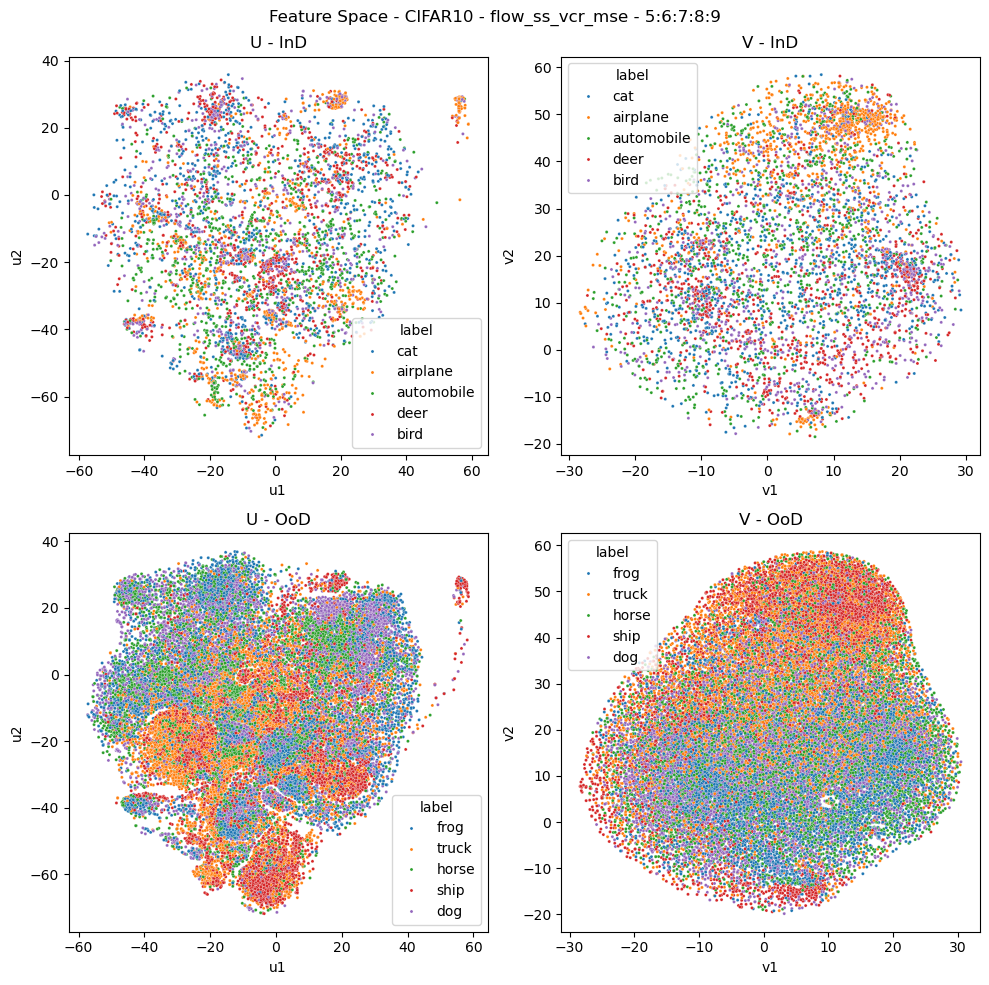

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:01<00:04,  1.34s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:02<00:02,  1.36s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:04<00:01,  1.40s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.49s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.45s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:05<00:16,  5.61s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:11<00:11,  5.64s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:16<00:05,  5.68s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.75s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.72s/it]

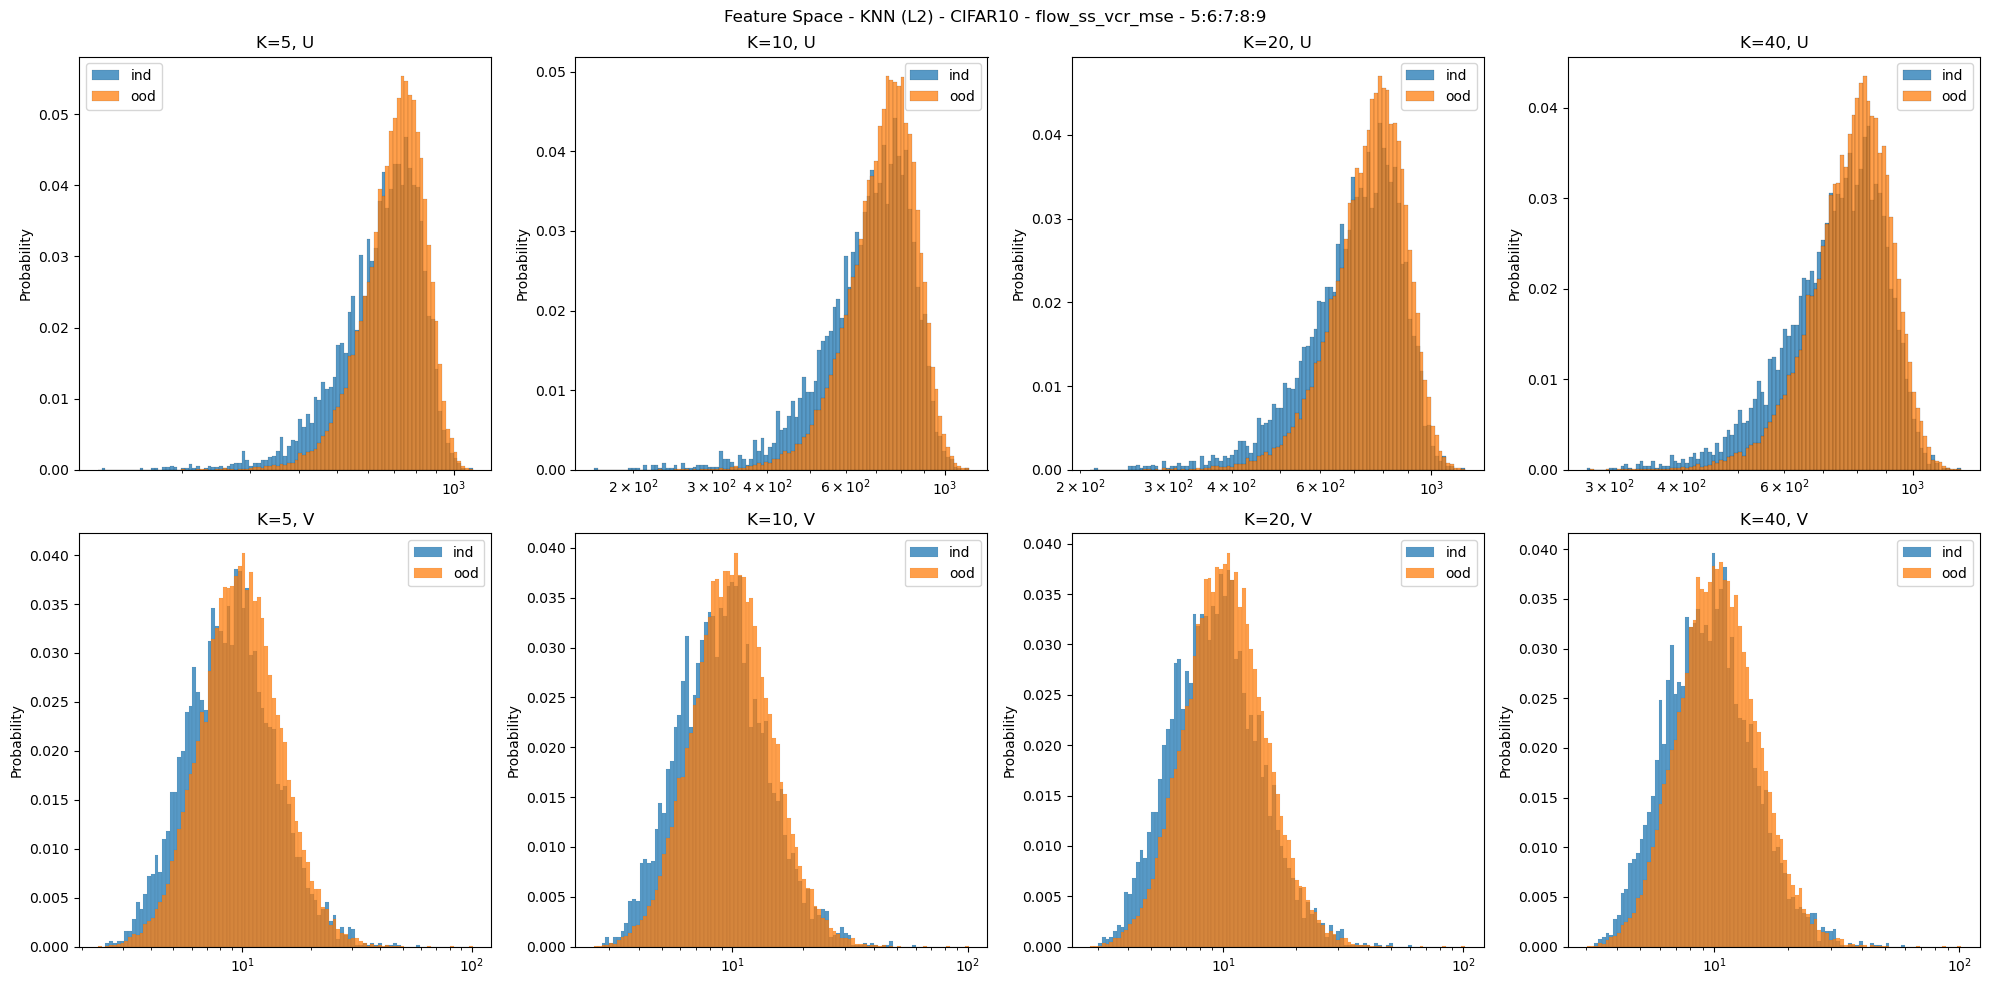

In [13]:
# plot knn to val data in feature space (L2)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:01<00:04,  1.35s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:02<00:02,  1.37s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:04<00:01,  1.42s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.50s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.46s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:05<00:16,  5.56s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:11<00:11,  5.66s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:17<00:05,  5.82s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.82s/it]

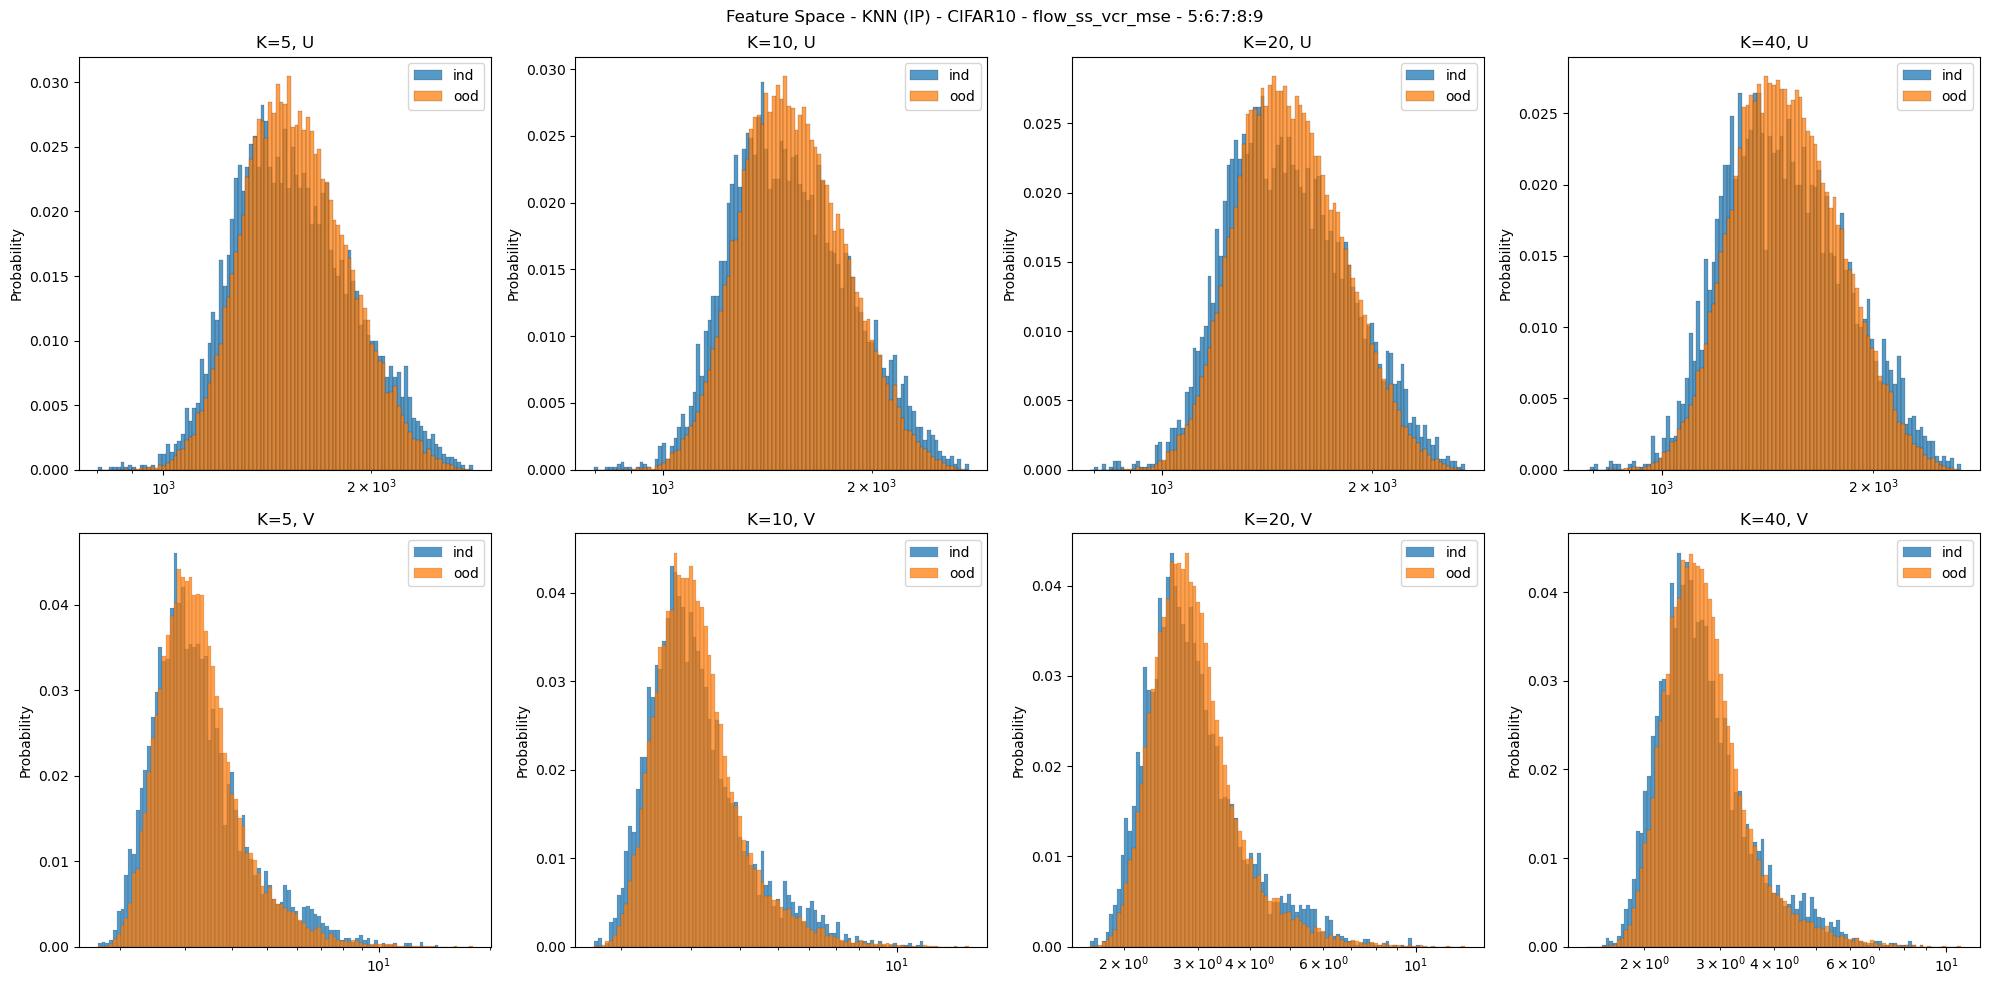

In [14]:
# plot knn to val data in feature space (IP)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

41.809017 3.5905216 3.0675004 0.6805448
41.767612 3.6644597 3.0653415 0.6871576
41.801273 3.6663089 3.0690165 0.68533987
42.14132 3.1195476 3.1870203 0.640616
55.555645 2.3727682 46.274014 0.7346312


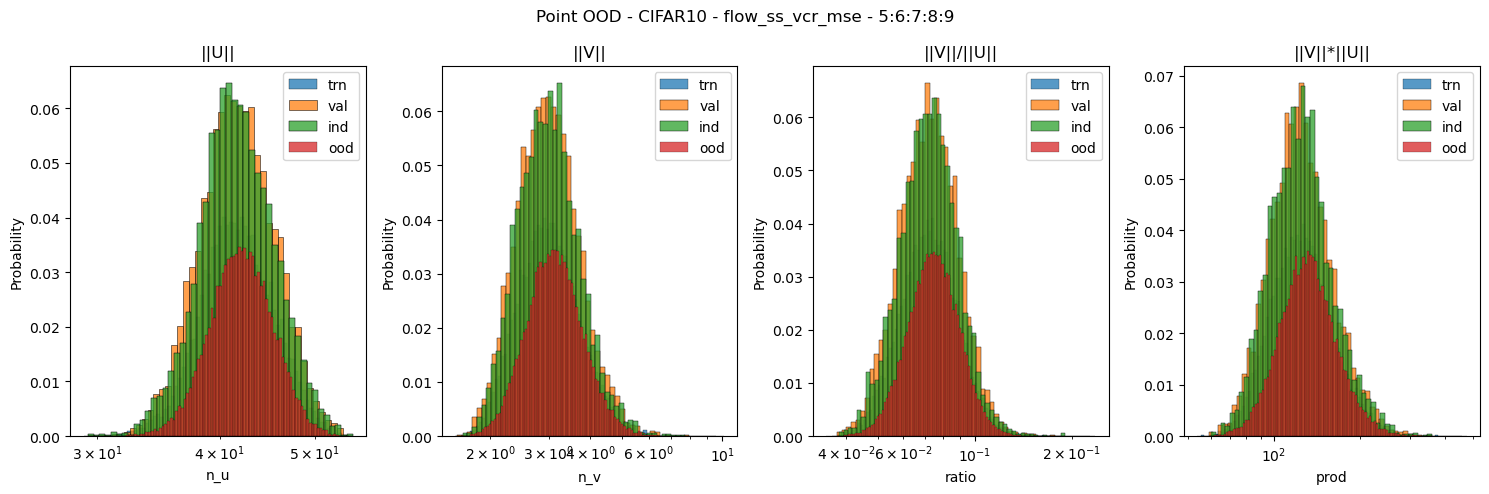

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


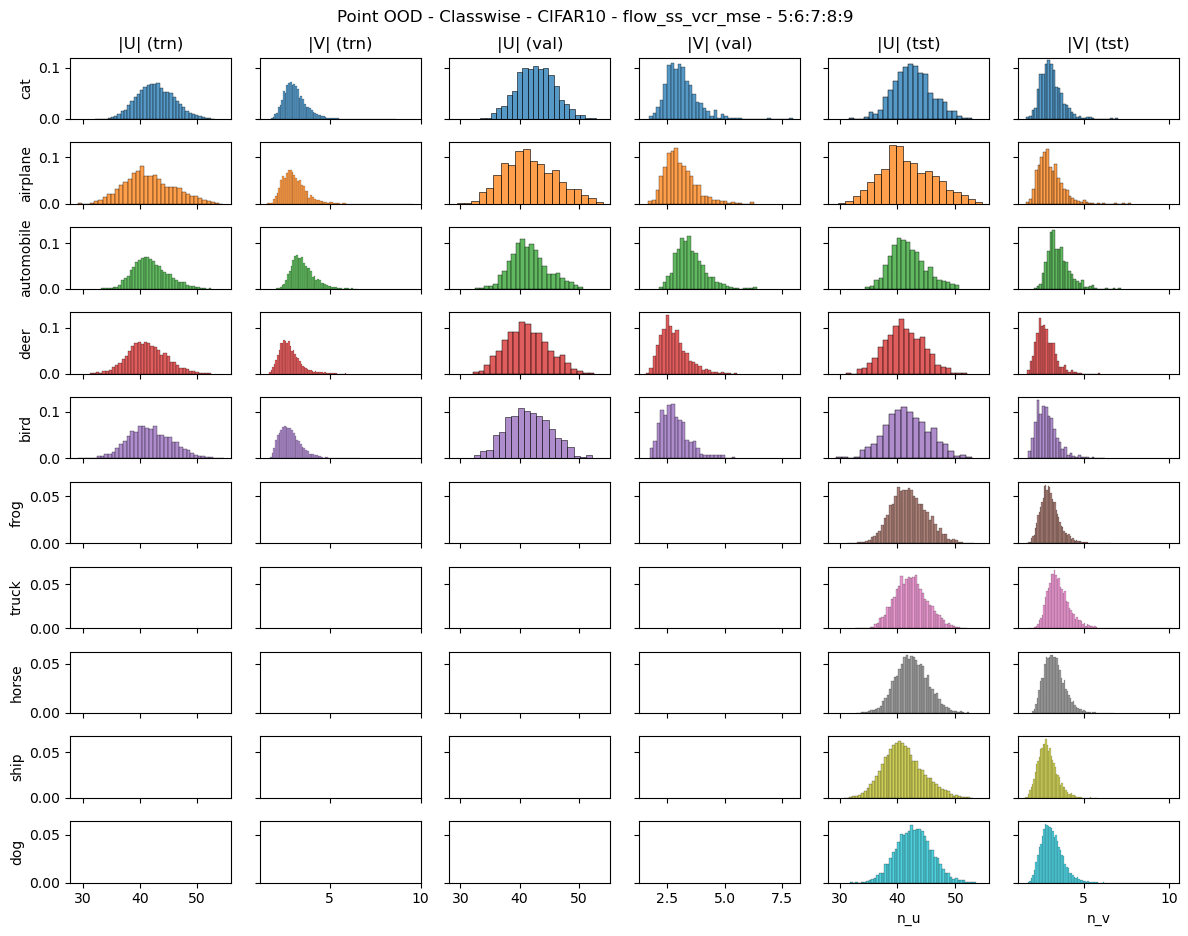

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

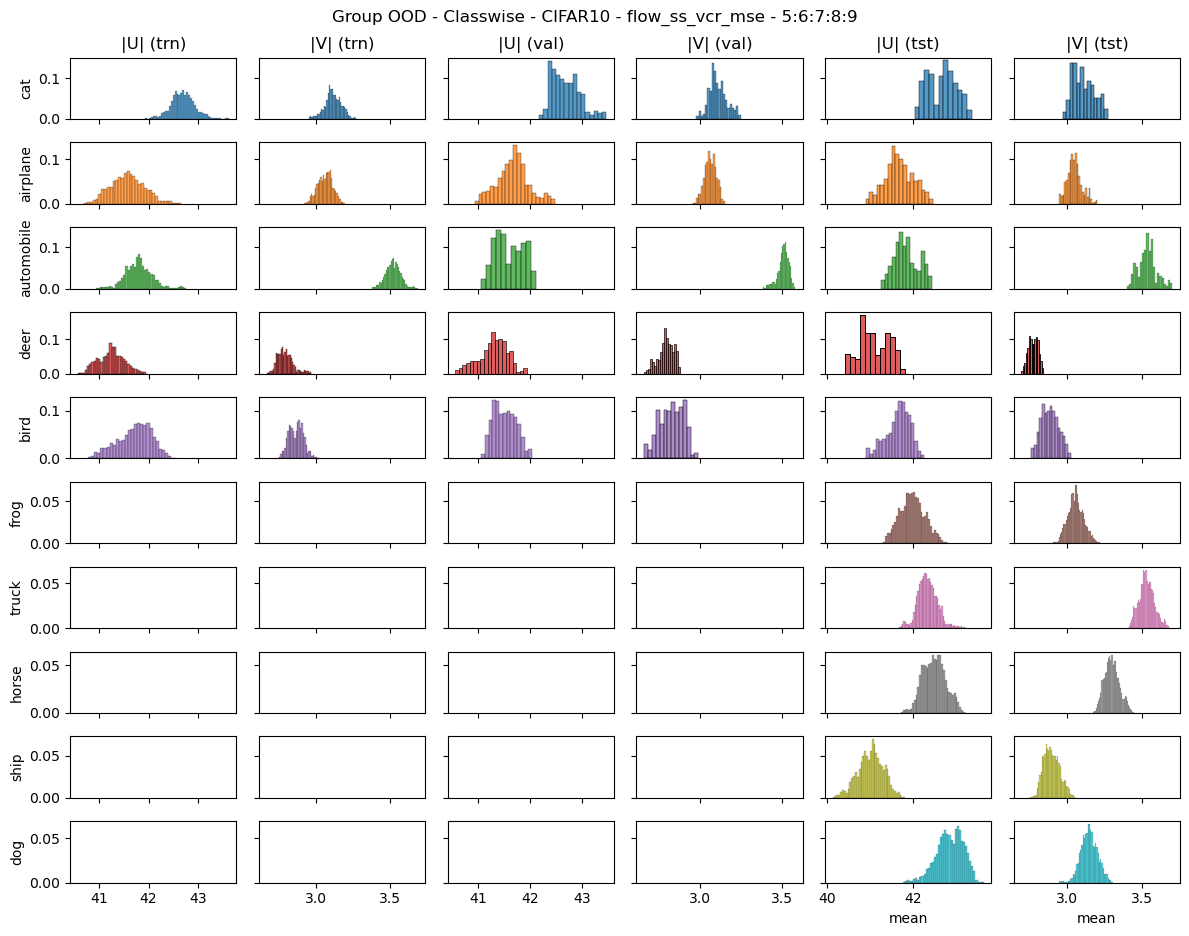

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

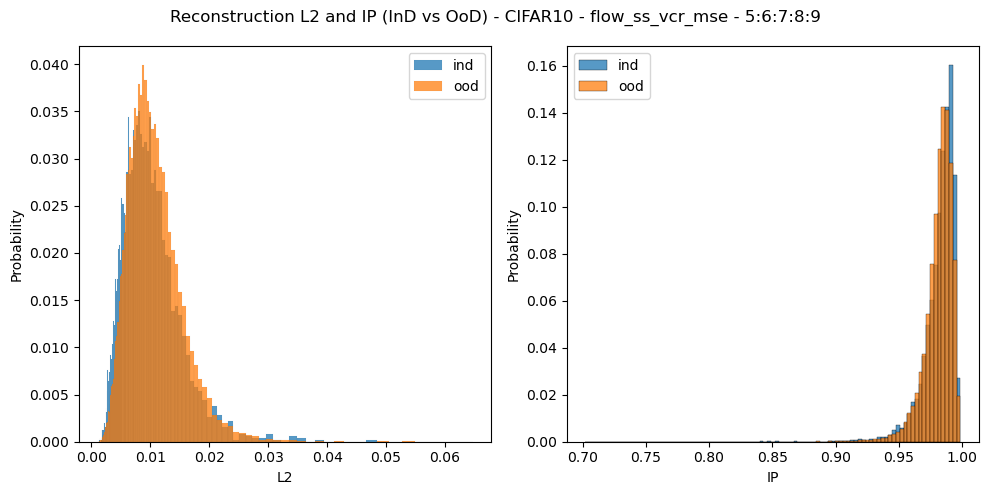

In [20]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()